In [2]:
from torch.autograd import Variable
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as tfm

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class HookLayer():
    def __init__(self, module):
        self.hook = module.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.clone().requires_grad_(True).cuda()
    def close(self):
        self.hook.remove()

In [4]:
normalize = tfm.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
inv_normalize = tfm.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                              std=[1/0.229, 1/0.224, 1/0.255])

### VGG16 model

In [5]:
model = models.vgg16_bn(True).cuda().eval()
model = list(model.children())[0]

Loss is  -17.180912017822266


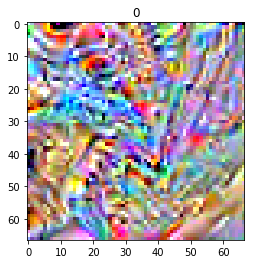

Loss is  -21.363618850708008


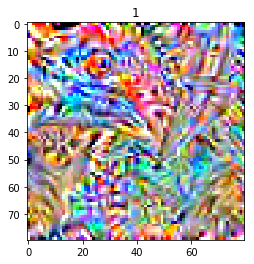

Loss is  -28.22054672241211


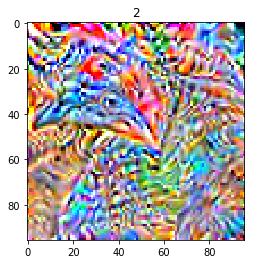

Loss is  -28.89944076538086


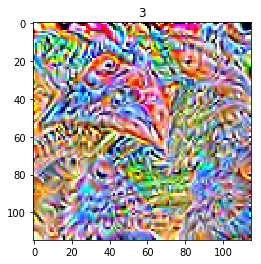

Loss is  -29.03495216369629


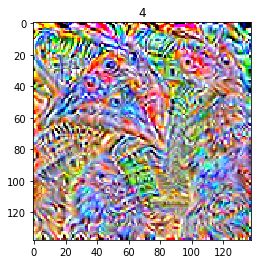

Loss is  -29.435039520263672


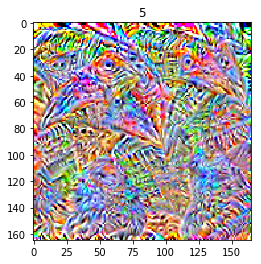

Loss is  -27.608463287353516


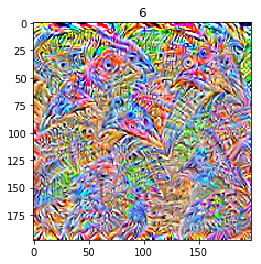

Loss is  -26.63098907470703


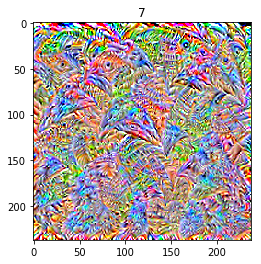

In [6]:
size = 56
img = np.uint8(np.random.uniform(150, 180, (size, size, 3)))/255

layer = 40
filter_ = 256
norm = True
activations = HookLayer(list(model.children())[layer])
for en in range(8): 
      
    img = torch.from_numpy(img).float().cuda()
    if norm:
        img = normalize(img)
    img = img.permute(2, 0, 1).unsqueeze(0)
    img = img.requires_grad_(True)
    
    optim = torch.optim.RMSprop([img], lr=0.1, alpha=0.5)
    for _ in range(100):    
        
        optim.zero_grad()
        model(img)
        loss = -activations.features[0, filter_].mean()
        loss.backward()
        optim.step()
        
    print("Loss is ", loss.item())
    size = int(1.2 * size) 
    
    img = img.squeeze(0)
    if norm:
        img = inv_normalize(img)
    img = img.cpu().detach().numpy().transpose(1,2,0)
    img = cv2.resize(img, dsize=(size, size), interpolation = cv2.INTER_CUBIC)
        
    inp = np.clip(img, 0, 1)
    plt.title(en)
    plt.imshow(inp)
    plt.pause(0.001)
    
activations.close()

The above outputs look like like some chicken :)

#### ResNet

In [7]:
model = models.resnet101(pretrained=True).cuda().eval()
model = nn.Sequential(*list(model.children())[:-1])

Loss is  -4.769207954406738


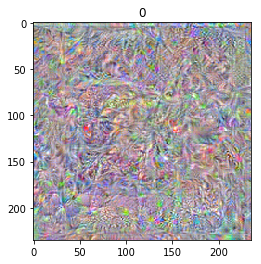

Loss is  -5.9472856521606445


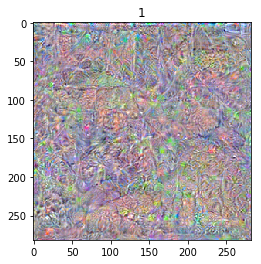

Loss is  -6.638817310333252


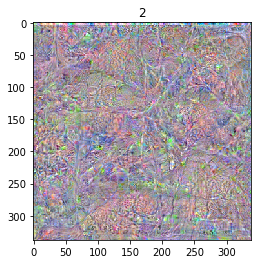

Loss is  -6.398026466369629


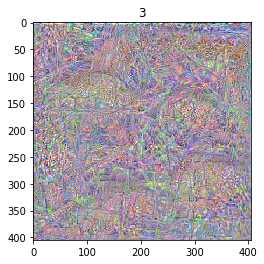

Loss is  -6.515442848205566


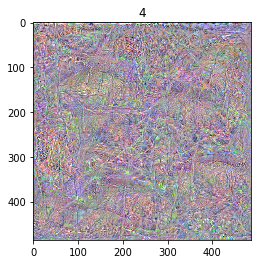

In [15]:
size = 196
img = np.uint8(np.random.uniform(150, 180, (size, size, 3)))/255

filter_ = 128
norm = True
activations = HookLayer(list(model[-2][-1].children())[-5])
for en in range(5): 
      
    img = torch.from_numpy(img).float().cuda()
    if norm:
        img = normalize(img)
    img = img.permute(2, 0, 1).unsqueeze(0)
    img = img.requires_grad_(True)
    
    optim = torch.optim.Adam([img], lr=0.05)
    for _ in range(200):           
        optim.zero_grad()
        model(img)
        loss = -activations.features[0, filter_].mean()
        loss.backward()
        optim.step()
    
    print("Loss is ", loss.item())
    size = int(1.2 * size) 
    img = img.squeeze(0)
    if norm:
        img = inv_normalize(img)
    img = img.cpu().detach().numpy().transpose(1,2,0)
    img = cv2.resize(img, dsize=(size, size), interpolation = cv2.INTER_CUBIC)
        
    inp = np.clip(img, 0, 1)
    plt.title(en)
    plt.imshow(inp)
    plt.pause(0.001)
    
activations.close()

In [31]:
inception = models.googlenet(pretrained=True)


AttributeError: module 'torchvision.models' has no attribute 'googlenet'

In [32]:
torch.__version__

'1.0.0'

#### The results of ResNet are really messy, so if you are passionate to train more efficiently, then welcome!